In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt 
import mpmath
import timeit

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("./ZERN/"))

from zern.zern_core import Zernike
import numpy as np

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("./zernike/"))
from zernike import RZern

sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("./zernpy/src/"))
from zernpy import ZernPol

from zernipax.basis import ZernikePolynomial
from zernipax.zernike import *
from zernipax.plotting import plot_comparison
from zernipax.backend import jax

using JAX backend, jax version=0.4.14, jaxlib version=0.4.14, dtype=float64
Using device: CPU, with 178.83 GB available memory


In [26]:
res = 50
basis = ZernikePolynomial(L=res, M=res, spectral_indexing="ansi", sym="cos")
ms = basis.modes[:,1]
ns = basis.modes[:,0]
r = np.linspace(0, 1, 100)

In [27]:
def fun_zernipax_clear(ns, ms, r):
    jax.clear_caches()
    return zernike_radial(r, ns, ms, 0)

def fun_zernipax(ns, ms, r):
    return zernike_radial(r, ns, ms, 0)

# %timeit fun_zernipax(ns, ms, r).block_until_ready()
# %timeit fun_zernipax_clear(ns, ms, r).block_until_ready()
all_zernipax = fun_zernipax(ns, ms, r)

In [28]:
def fun_zern(ns, ms, r):
    zern = Zernike(0)
    all = []
    for i in range(len(ms)): 
        all.append(zern.R_nm_Jacobi(int(ns[i]), int(ms[i]), r))

    return np.array(all)

all_zern = fun_zern(ns, ms, r).T

In [29]:
def get_Noll(n, m):
    j = n*(n+1)//2 + abs(m)
    if m >= 0 and (n%4 == 2 or n%4 == 3):
        j += 1
    elif m <= 0 and (n%4 == 0 or n%4 == 1):
        j += 1
    return j

def fun_zernike(ns, ms, r):
    all = []
    cart = RZern(int(max(ns)))
    for i in range(len(ms)):
        id_Noll = get_Noll(ns[i], ms[i]) - 1
        all.append(cart.Rnm(id_Noll, r))

    return np.array(all)

all_zernike = fun_zernike(ns, ms, r).T

In [30]:
def fun_zernpy(ns, ms, r):
    all = []
    for i in range(len(ms)):
        zp = ZernPol(m=int(ms[i]), n=int(ns[i]))   
        all.append(zp.radial(r))

    return np.array(all)

all_zernpy = fun_zernpy(ns, ms, r).T

In [31]:
# Exact computation
mpmath.mp.dps = 100
def fun_exact(ns, ms, r):
    c = zernike_radial_coeffs(ns, ms, exact=True)
    zt0 = np.array([np.asarray(mpmath.polyval(list(ci), r), dtype=float) for ci in c]).T
    return zt0

exact = fun_exact(ns, ms, r)

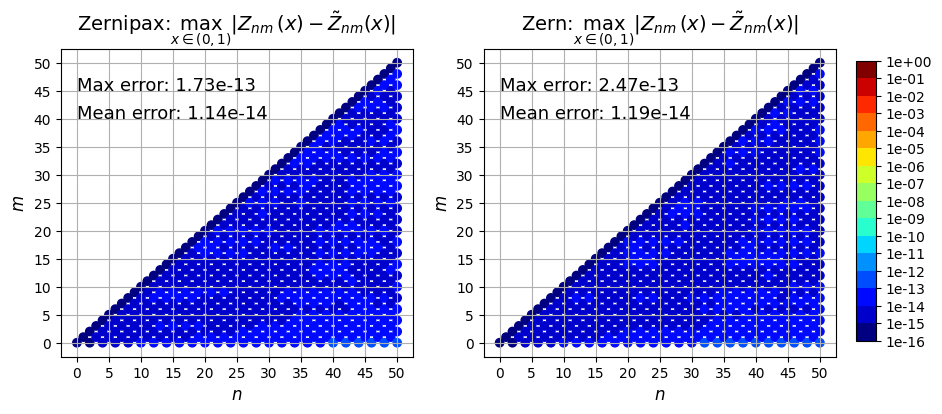

In [32]:
plot_comparison(
    exact, 
    (all_zernipax, all_zern),
    basis, 
    dx=0, 
    type="absolute", 
    names=("Zernipax:", "Zern:"), 
    print_error=True
)

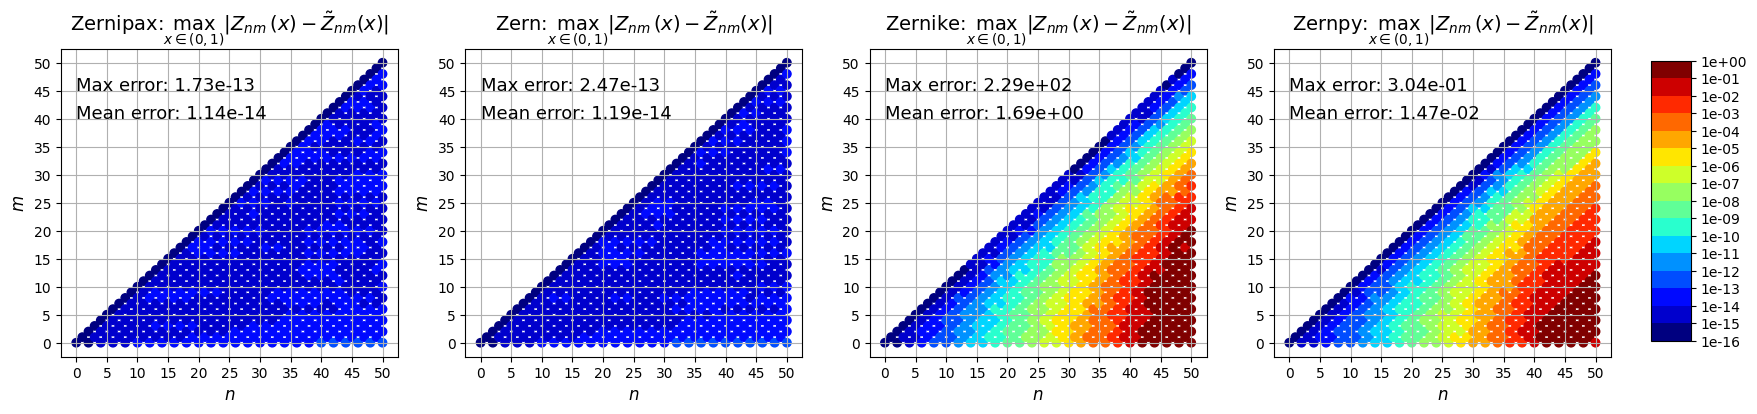

In [33]:
plot_comparison(
    exact, 
    (all_zernipax, all_zern, all_zernike, all_zernpy),
    basis, 
    dx=0, 
    type="absolute", 
    names=("Zernipax:", "Zern:", "Zernike:", "Zernpy:"), 
    print_error=True
)
plt.savefig("comparison_all.png", dpi=1000)

In [10]:
print("Time for ZERN:")
%timeit fun_zern(ns, ms, r);
print("Time for ZERNIKE:")
%timeit fun_zernike(ns, ms, r);
# print("Time for ZERNPY:")
# %timeit fun_zernpy(ns, ms, r);
print("Time for ZERNIPAX:")
%timeit fun_zernipax(ns, ms, r).block_until_ready();

Time for ZERN:
89.9 ms ± 284 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time for ZERNIKE:
106 ms ± 928 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Time for ZERNIPAX:
2.09 ms ± 553 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
r = np.linspace(0, 1, 100)
times = []
num_exec = 100
range_res = np.arange(10, 101, 5)
from tqdm import tqdm

for res in tqdm(range_res):
    basis = ZernikePolynomial(L=res, M=res, spectral_indexing="ansi", sym="cos")
    ms = basis.modes[:,1]
    ns = basis.modes[:,0]
    _ = fun_zernipax(ns, ms, r) # run to compile it once

    t1 = timeit.timeit(lambda: fun_zern(ns, ms, r), number=num_exec)
    t2 = timeit.timeit(lambda: fun_zernike(ns, ms, r), number=num_exec)
    t3 = timeit.timeit(lambda: fun_zernipax(ns, ms, r).block_until_ready(), number=num_exec)
    t4 = timeit.timeit(lambda: fun_zernipax_clear(ns, ms, r).block_until_ready(), number=num_exec)

    times.append([t1, t2, t3, t4])
times = np.array(times)*1000/num_exec

100%|██████████| 19/19 [26:11<00:00, 82.70s/it] 


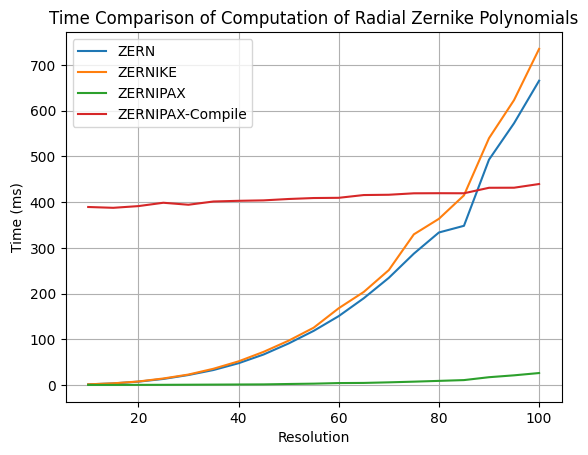

In [23]:
plt.plot(range_res, times[:,0], label="ZERN")
plt.plot(range_res, times[:,1], label="ZERNIKE")
plt.plot(range_res, times[:,2], label="ZERNIPAX")
plt.plot(range_res, times[:,3], label="ZERNIPAX-Compile")
# plt.plot(range_res, 0.001*range_res**3, label="order")
plt.xlabel("Resolution")
plt.ylabel("Time (ms)")
plt.title("Time Comparison of Computation of Radial Zernike Polynomials")
plt.grid()
plt.legend()
plt.savefig("time_comparison_compile.pdf", dpi=1000)

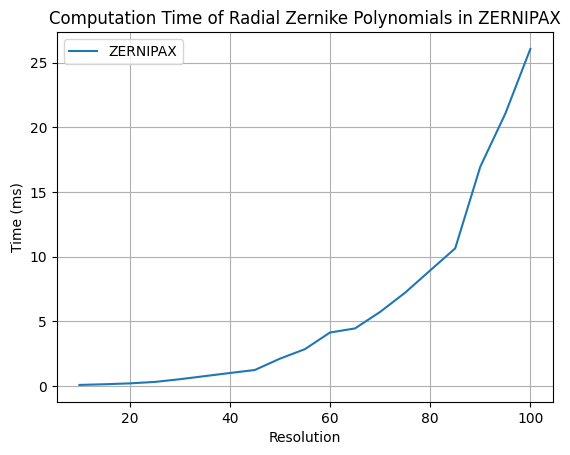

In [24]:
plt.plot(range_res, times[:,2], label="ZERNIPAX")
# plt.plot(range_res, 0.00003*range_res**3, label="order")
plt.xlabel("Resolution")
plt.ylabel("Time (ms)")
plt.title("Computation Time of Radial Zernike Polynomials in ZERNIPAX")
plt.grid()
plt.legend()
plt.savefig("time_zernipax.pdf", dpi=1000)